https://github.com/pymc-devs/pymc3/pull/2876

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pylab as plt

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Cherry picked commit

In [17]:
from pymc3.model import modelcontext, get_named_nodes_and_relations
from pymc3.util import is_transformed_name
from tqdm import tqdm


def sample_prior(samples=500, model=None, vars=None, size=None,
                 random_seed=None, progressbar=True):
    """Generate samples from the prior of a model.

    Parameters
    ----------
    samples : int
        Number of samples from the prior to generate. Defaults to 500.
    model : Model (optional if in `with` context)
    vars : iterable
        Variables for which to compute the posterior predictive samples.
        Defaults to `model.named_vars`.
    size : int
        The number of random draws from the distribution specified by the
        parameters in each sample of the trace.
    random_seed : int
        Seed for the random number generator.
    progressbar : bool
        Whether or not to display a progress bar in the command line.

    Returns
    -------
    dict
        Dictionary with the variables as keys. The values are arrays of prior samples.
    """

    model = modelcontext(model)

    if vars is None:
        vars = set(model.named_vars.keys())

    if random_seed is not None:
        np.random.seed(random_seed)

    if progressbar:
        indices = tqdm(range(samples))

    def step(model):
        point = {}
        for var in model.basic_RVs:
            var_name = var.name
            if hasattr(var, 'distribution'):
                if is_transformed_name(var_name):
                    val = var.distribution.dist.random(
                        point=point, size=size)
                else:
                    val = var.distribution.random(point=point, size=size)
            else:
                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})

            point[var_name] = val
        return point

    try:
        prior = {var: [] for var in vars}
        for _ in indices:
            point = step(model)
            for var_name, var in model.named_vars.items():
                if var_name in vars:
                    if var_name in point:
                        val = point[var_name]
                    else:
                        nn, _, _ = get_named_nodes_and_relations(var)
                        val = var.eval({model.named_vars[v]: point[v]
                                        for v in nn})
                    prior[var_name].append(val)

    except KeyboardInterrupt:
        pass

    finally:
        if progressbar:
            indices.close()

    return {k: np.asarray(v) for k, v in prior.items()}

In [18]:
observed = np.random.normal(10, 1, size=200)
with pm.Model() as m: 
    # Use a prior that's way off to show we're actually sampling from it 
    mu = pm.Normal('mu', mu=-10, sd=1) 
    positive_mu = pm.Deterministic('positive_mu', np.abs(mu)) 
    pm.Normal('x_obs', mu=mu, sd=1, observed=observed) 
    prior = sample_prior() 

assert (prior['mu'] < 0).all() 
assert (prior['positive_mu'] > 0).all() 
assert (prior['x_obs'] < 0).all()

100%|██████████| 500/500 [00:00<00:00, 1552.88it/s]


In [19]:
data = pd.read_table(pm.get_data('efron-morris-75-data.tsv'), sep="\t")
at_bats, hits = data[['At-Bats', 'Hits']].values.T
N = len(hits)

with pm.Model() as model:
    phi = pm.Beta('phi', alpha=1., beta=1.)

    kappa_log = pm.Exponential('logkappa', lam=5.)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=N)

    y = pm.Binomial('y', n=at_bats, p=thetas, shape=N, observed=hits)
    p = sample_prior()

100%|██████████| 500/500 [00:04<00:00, 103.53it/s]


In [20]:
y.distribution.random(point=model.test_point, size=1000)

array([[44, 12, 11, ...,  1, 44, 34],
       [44, 16, 14, ...,  2, 45, 34],
       [45, 10, 11, ...,  1, 44, 36],
       ...,
       [44, 14, 10, ...,  1, 45, 37],
       [45, 17, 12, ...,  2, 45, 36],
       [45,  8, 10, ...,  3, 45, 37]])

In [21]:
np.random.binomial(45, thetas.tag.test_value, size=(1000, N))

array([[17, 25, 25, ..., 17, 22, 22],
       [25, 23, 22, ..., 22, 24, 19],
       [15, 17, 26, ..., 17, 17, 20],
       ...,
       [25, 21, 23, ..., 21, 25, 23],
       [25, 25, 24, ..., 18, 18, 21],
       [23, 23, 21, ..., 26, 24, 26]])

In [22]:
# names = ['phi', 'kappa_log', 'kappa', 'thetas', 'y']
# values = pm.distributions.draw_values([model[name] for name in names], size=100)
# p = {k: v for k, v in zip(names, values)}

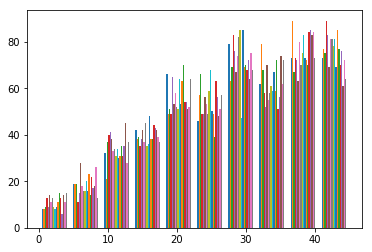

In [23]:
plt.hist(p['y']);

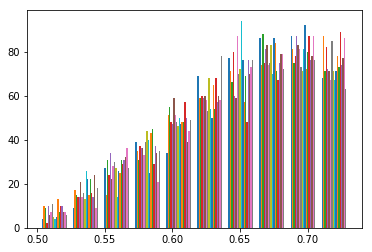

In [24]:
plt.hist(p['thetas']);

In [25]:
p['thetas'].mean(axis=0) * at_bats

array([29.34708329, 29.35583373, 29.14527202, 29.34525447, 29.15791982,
       29.19624311, 29.19291743, 29.18451562, 29.17041436, 29.19146721,
       29.31792479, 29.12467176, 29.06444945, 29.26633796, 29.16134512,
       29.15881446, 29.4247327 , 29.08408229])

In [26]:
p['y'].mean(axis=0)

array([27.762, 29.066, 27.686, 28.428, 27.89 , 26.764, 28.106, 27.726,
       28.432, 27.994, 27.872, 27.844, 27.828, 27.516, 28.158, 27.312,
       27.91 , 27.464])

##  Wrap in function 

In [35]:
from pymc3.step_methods.arraystep import BlockedStep
from pymc3.blocking import ArrayOrdering, DictToArrayBijection

class PriorStep(BlockedStep):
    """
    Blocked step method that is generalized to accept vectors of variables.

    Parameters
    ----------
    vars : list
        List of variables for sampler.
    model : PyMC Model
        Optional model for sampling step. Defaults to None (taken from context).
    allvars: Boolean (default True)
    blocked: Boolean (default True)
    """

    def __init__(self, vars=None, model=None, allvars=True, blocked=True):
        model = pm.modelcontext(model)

        if vars is None:
            vars = model.basic_RVs

        self.vars = vars
        self.model = model
        self.allvars = allvars
        self.blocked = blocked

    def step(self, point):
        model = self.model
        point = {}
        for var in self.vars:
            var_name = var.name
            if hasattr(var, 'distribution'):
                if is_transformed_name(var_name):
                    val = var.distribution.dist.random(
                        point=point, size=None)
                else:
                    val = var.distribution.random(point=point, size=None)
            else:
                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})

            point[var_name] = val

        for var_name, var in model.named_vars.items():
            if not var_name in point:

                nn, _, _ = get_named_nodes_and_relations(var)
                val = var.eval({model.named_vars[v]: point[v]
                                for v in nn})
            point[var_name] = val
        return point

In [37]:
with model:
    step = PriorStep()

In [38]:
step.step(model.test_point)

TypeError: Bad input argument to theano function with name "<ipython-input-17-a594ea16b4a0>:72" at index 0 (0-based). Wrong number of dimensions: expected 1, got 0 with shape ().

In [ ]:
names = pm.util.get_default_varnames(model.named_vars, include_transformed=False)
names